# Matplotlib overview
## Lunch bytes (LB21) - October 12th 2018

- Presentation is available on [Google Slide](https://docs.google.com/presentation/d/1ex2W37GNaqJuPDBvPReSPxffgCkjMS8ngZUpK9CgGcM/edit?usp=sharing).
- Datasets needed to run this notebook are on [Dropbox](https://www.dropbox.com/s/4av9yxlnbk21637/dataset.zip?dl=0).

## I got very little requests for this talk so I use my limited creativity.
- Contour plot
- Profile plot
- axis, tiks, legends, labels, fonts (maybe)
- Bathymetry with user data
- Cartopy
    - different projections
- Collections (Patch and Line)

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cmocean # colormaps for oceanography
import cartopy.crs as ccrs # cartopy projection
from netCDF4 import Dataset

%matplotlib inline 

# 1. Basic plots

## argo profiles

I selected a Argo float 1901295 because it's has a nice path (http://www.argodatamgt.org/Access-to-data/Description-of-all-floats2)

The data for this float was here and I put in dataset/argo_1901295 (ftp://usgodae.org/pub/outgoing/argo/dac/bodc/1901294/)

In [2]:
# get the trajectories
datafile = 'dataset/argo_1901294/1901294_prof.nc'
file = Dataset(datafile, 'r')
lon = file.variables['LONGITUDE'][:]
lat = file.variables['LATITUDE'][:]
time = file.variables['JULD'][:]
file.close()

print('The floats drifted for %d days. (is this possible !?)' % (time[-1] - time[0]))

The floats drifted for 2690 days. (is this possible !?)


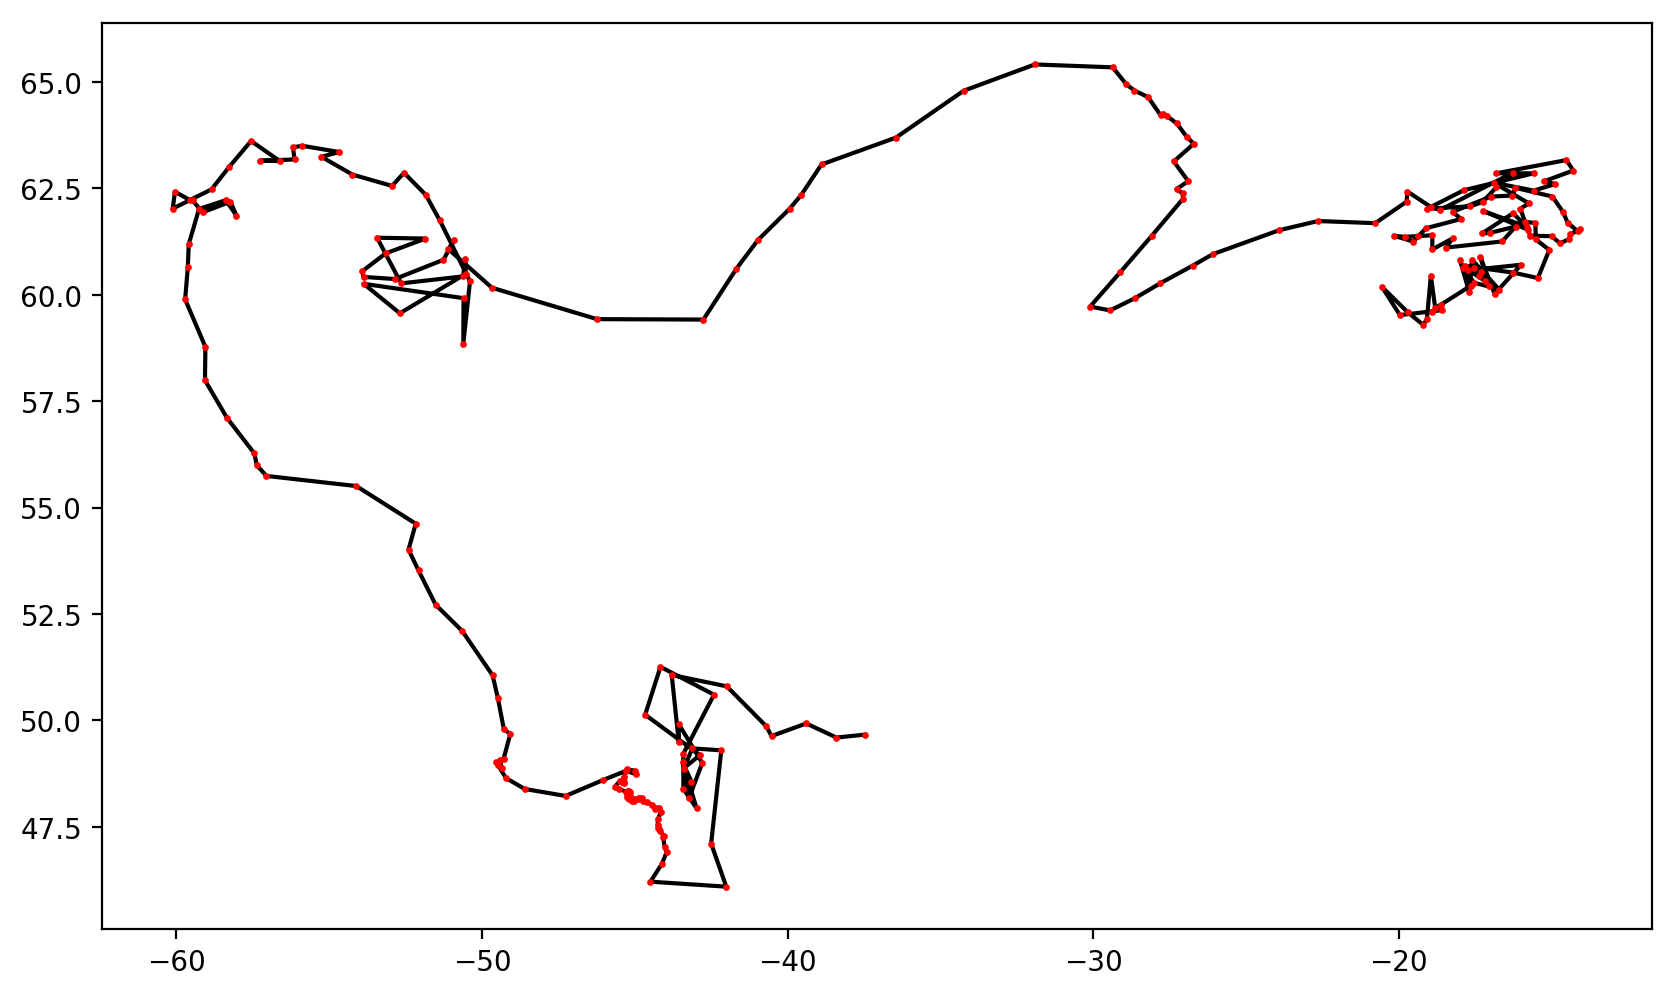

In [3]:
fig = plt.figure(figsize=(10,6), dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(lon, lat, 'black', zorder=0)
ax.scatter(lon, lat, s=2, color='red', zorder=1)

In [4]:
# plot one profile
profile_file = 'dataset/argo_1901294/profiles/R1901294_001.nc'
file = Dataset(profile_file, 'r')
temp = file.variables['TEMP'][:].squeeze()
psal = file.variables['PSAL'][:].squeeze()
pres = file.variables['PRES'][:].squeeze()
file.close()

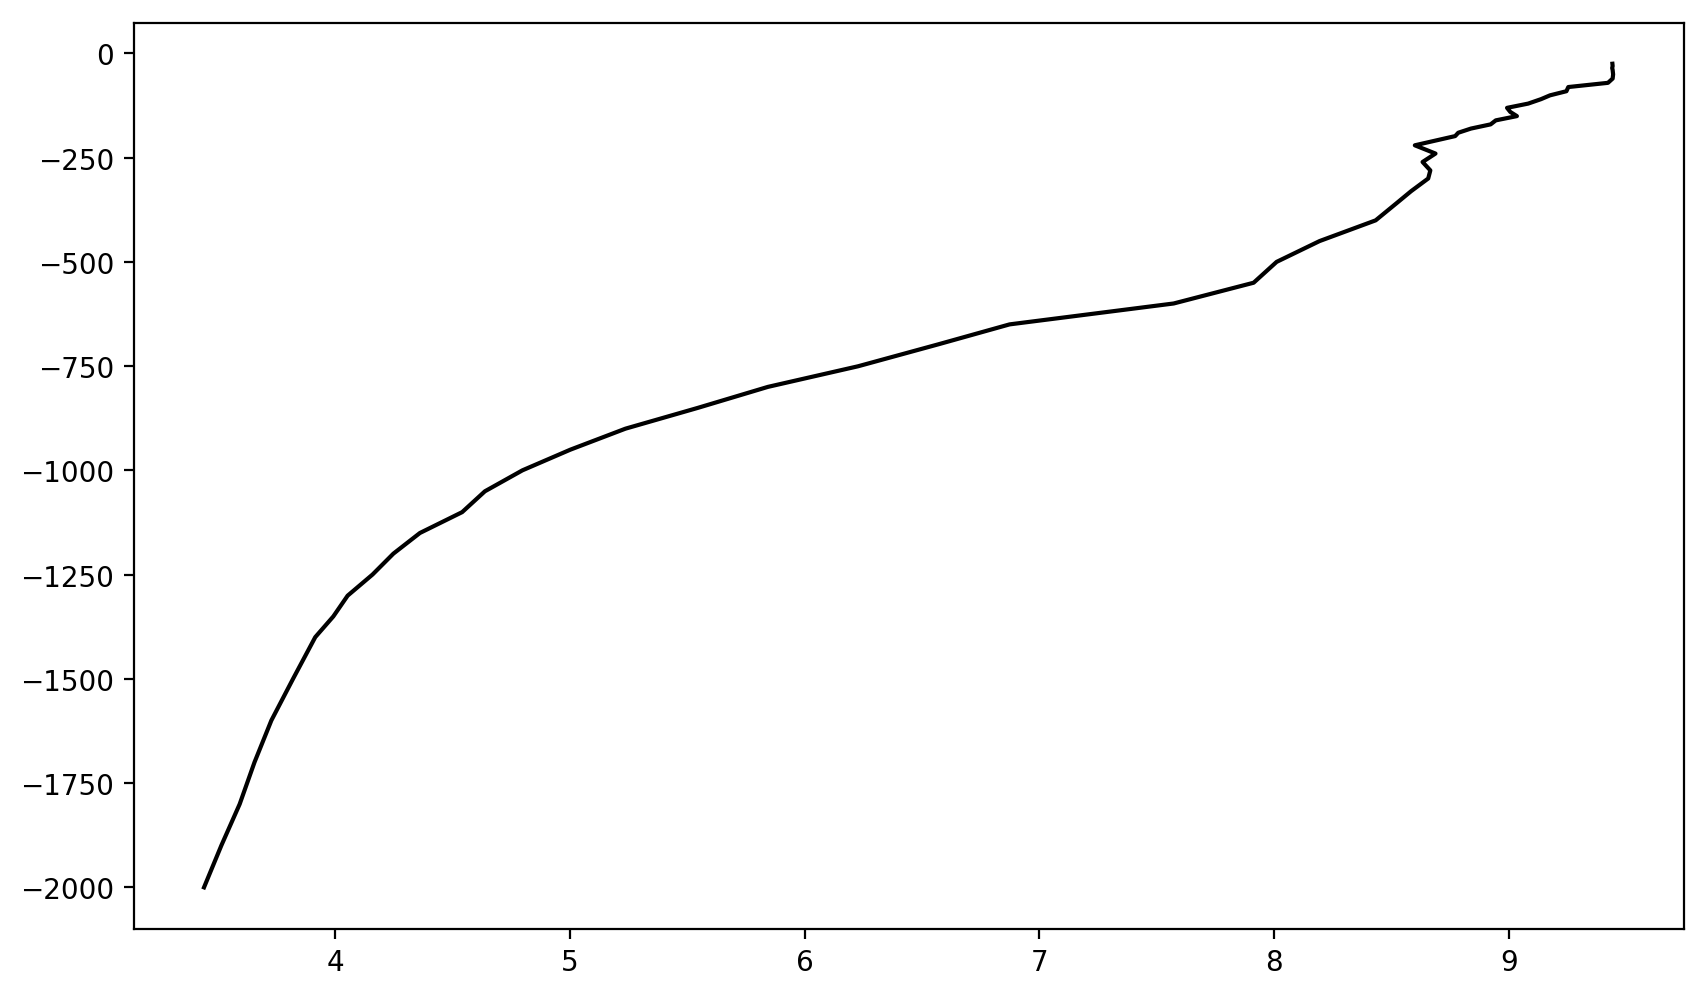

In [5]:
fig = plt.figure(figsize=(10,6), dpi=200)
ax = fig.add_subplot(1,1,1)
ax.plot(temp, -pres, 'black', zorder=0) # -press in dbar to get ~depth in meters

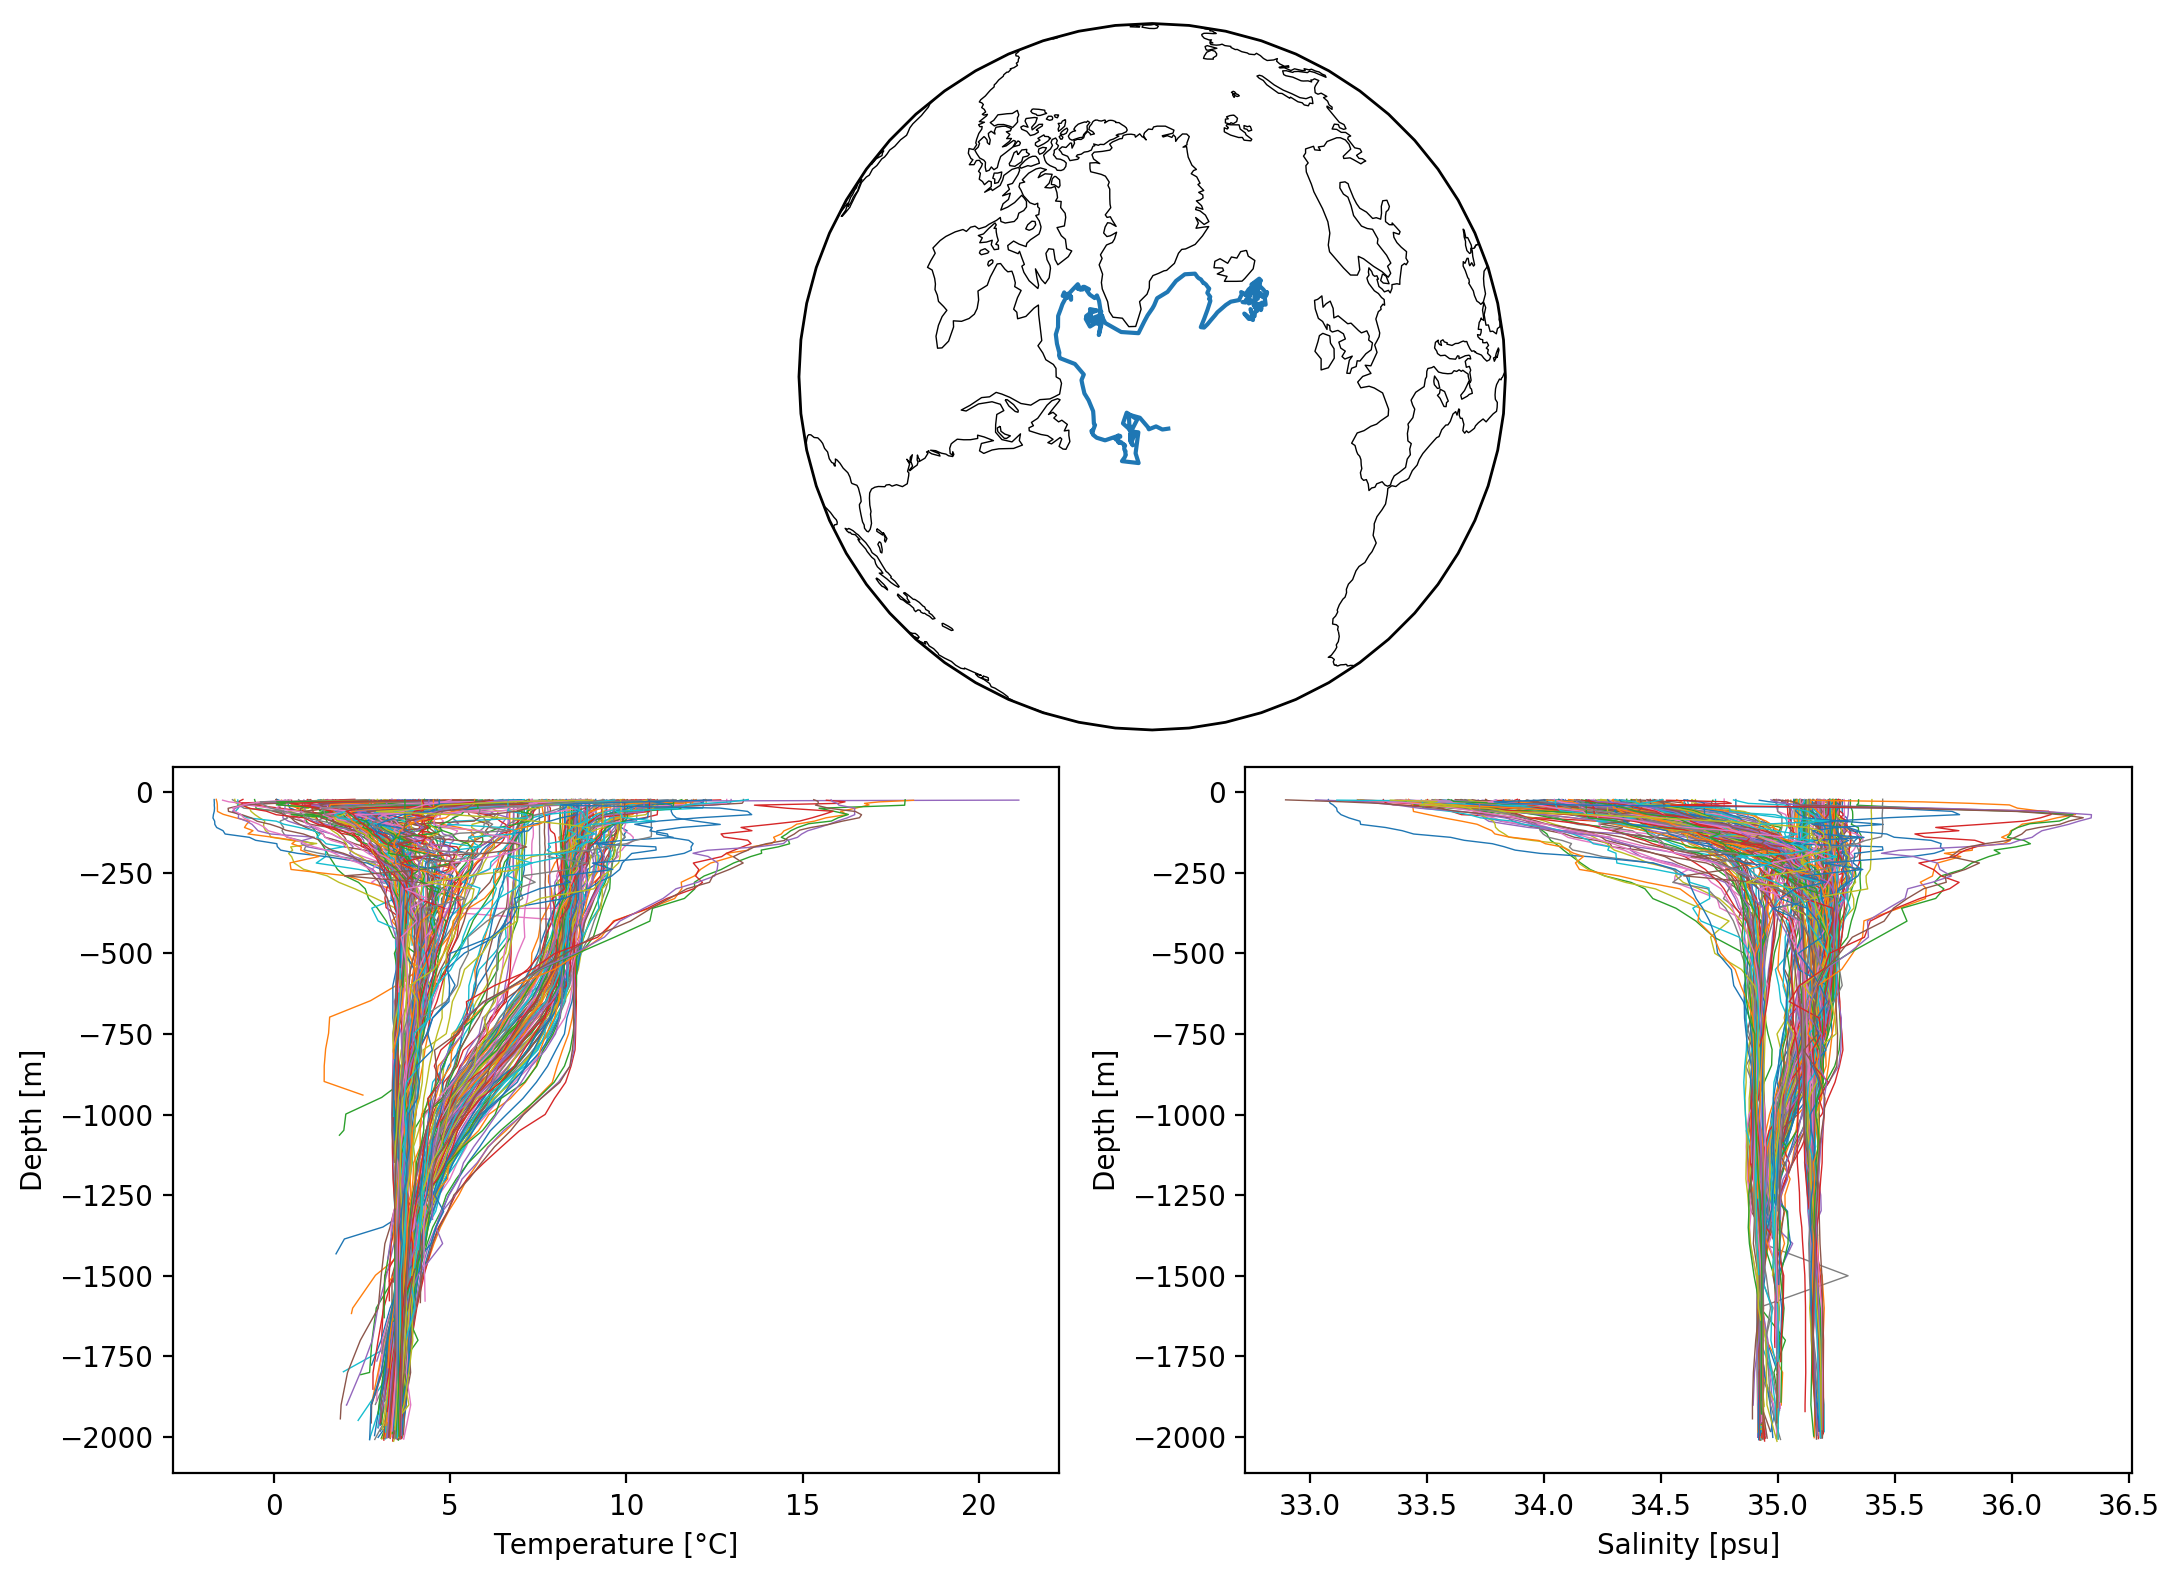

In [6]:
# plot all profiles of this float
fig = plt.figure(figsize=(11,8), dpi=200)
ax1 = fig.add_subplot(2,2,3)
ax2 = fig.add_subplot(2,2,4)

for i in range(1, 271):
    if i not in [150, 174, 213, 214]: # 150 has a wrong salinity point, the others are missing
        profile_file = 'dataset/argo_1901294/profiles/R1901294_%03d.nc' % i
        file = Dataset(profile_file, 'r')
        temp = file.variables['TEMP'][:].squeeze()
        psal = file.variables['PSAL'][:].squeeze()
        pres = file.variables['PRES'][:].squeeze()
        ax1.plot(temp, -pres, linewidth=0.5) # -press in dbar to get ~depth in meters
        ax2.plot(psal, -pres, linewidth=0.5) # -press in dbar to get ~depth in meters

        
ax1.set_xlabel('Temperature [°C]')
ax1.set_ylabel('Depth [m]')
ax2.set_xlabel('Salinity [psu]')
ax2.set_ylabel('Depth [m]')


# third axis for the trajectories with cartopy
import cartopy.crs as ccrs
ax3 = fig.add_subplot(2,1,1, projection=ccrs.NearsidePerspective(central_longitude=-40, central_latitude=55, satellite_height=10000000))
ax3.coastlines(linewidths=0.5)

datafile = 'dataset/argo_1901294/1901294_prof.nc'
file = Dataset(datafile, 'r')
lon = file.variables['LONGITUDE'][:]
lat = file.variables['LATITUDE'][:]
time = file.variables['JULD'][:]
ax3.plot(lon, lat, transform=ccrs.PlateCarree())
ax3.set_global()
fig.tight_layout()

Text(0.5,1,'Size of Panulirus interruptus at the Rickenbacker Causeway bridge')

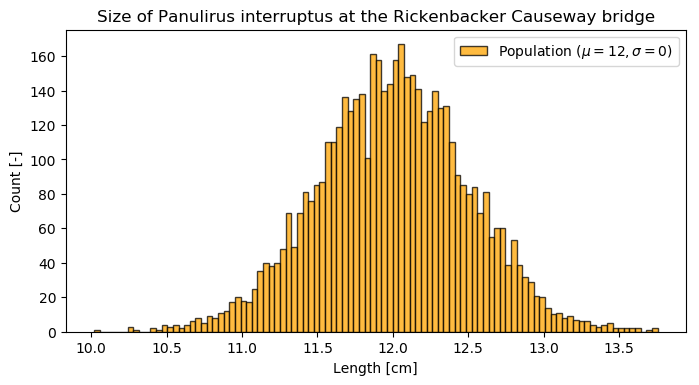

In [7]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax = fig.add_subplot(1,1,1)

# generate fake data
mu, sigma = 12, 0.5
x = mu + sigma*np.random.randn(5000)

# the histogram of the data
n, bins, patches = plt.hist(x, 100, facecolor='orange', edgecolor='black', alpha=0.75)
ax.legend([r'Population ($\mu =%d, \sigma = %d$)' % (mu, sigma)])
ax.set_xlabel('Length [cm]')
ax.set_ylabel('Count [-]')
ax.set_title('Size of Panulirus interruptus at the Rickenbacker Causeway bridge')

# Bathymetry from external dataset
## ETOPO1 is a 1 arc-minute global relief model of Earth's surface that integrates land topography and ocean bathymetry.

This function is to format the axis to °W-°E and °S-°N and only keep a multiple of nx,ny values on each axis.

In [8]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

# add degree °W and °E and remove negative sign
def label_lon(x, pos):
    """The two args are the value and tick position"""
    if x > 0:
        return '%d°E' % x
    else:
        return '%d°W' % -x

# add °N and °S and remove negative sign
def label_lat(x, pos):
    """The two args are the value and tick position"""
    if x > 0:
        return '%d°N' % x
    else:
        return '%d°S' % -x


def format_axis(ax, nx=None, ny=None):
    """Function to clean up the axis of a figure
        nx,ny are the multiple in x,y axis"""
    if nx is None and ny is None:
        # keep the border but hide ticks and labels
        # ax.set_axis_off() remove border, ticks, labels
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    else:
        ax.xaxis.set_major_locator(MultipleLocator(nx))
        ax.xaxis.set_major_formatter(FuncFormatter(label_lon))
        ax.yaxis.set_major_locator(MultipleLocator(ny))
        ax.yaxis.set_major_formatter(FuncFormatter(label_lat))

Function to load the bathymetry from the ETOPO1 dataset and keep values inside the box define by the two list lon = [lonmin, lonmax] and lat = [latmin, latmax] given in parameters.

In [9]:
def bathymetry_etopo(lon, lat):
    """
    Return the bathymetry for the regions specified by the input parameters
    lon: list containing min/max values of the longitude
    lat: list containing min/max values of the latitude
    """
    folder = 'dataset/etopo1/'
    nc = Dataset(folder + 'ETOPO1_Ice_c_gmt4.grd', 'r')
    elon = nc.variables['x'][...]
    elat = nc.variables['y'][...]
    
    # get bathymetry inside the region
    i0 = np.argmin((min(lon) - elon) ** 2)
    i1 = np.argmin((max(lon) - elon) ** 2)
    j0 = np.argmin((min(lat) - elat) ** 2)
    j1 = np.argmin((max(lat) - elat) ** 2)
    
    elon = elon[i0:i1]
    elat = elat[j0:j1]
    ez = nc.variables['z'][j0:j1, i0:i1]
    nc.close()
    
    
    return elon, elat, ez

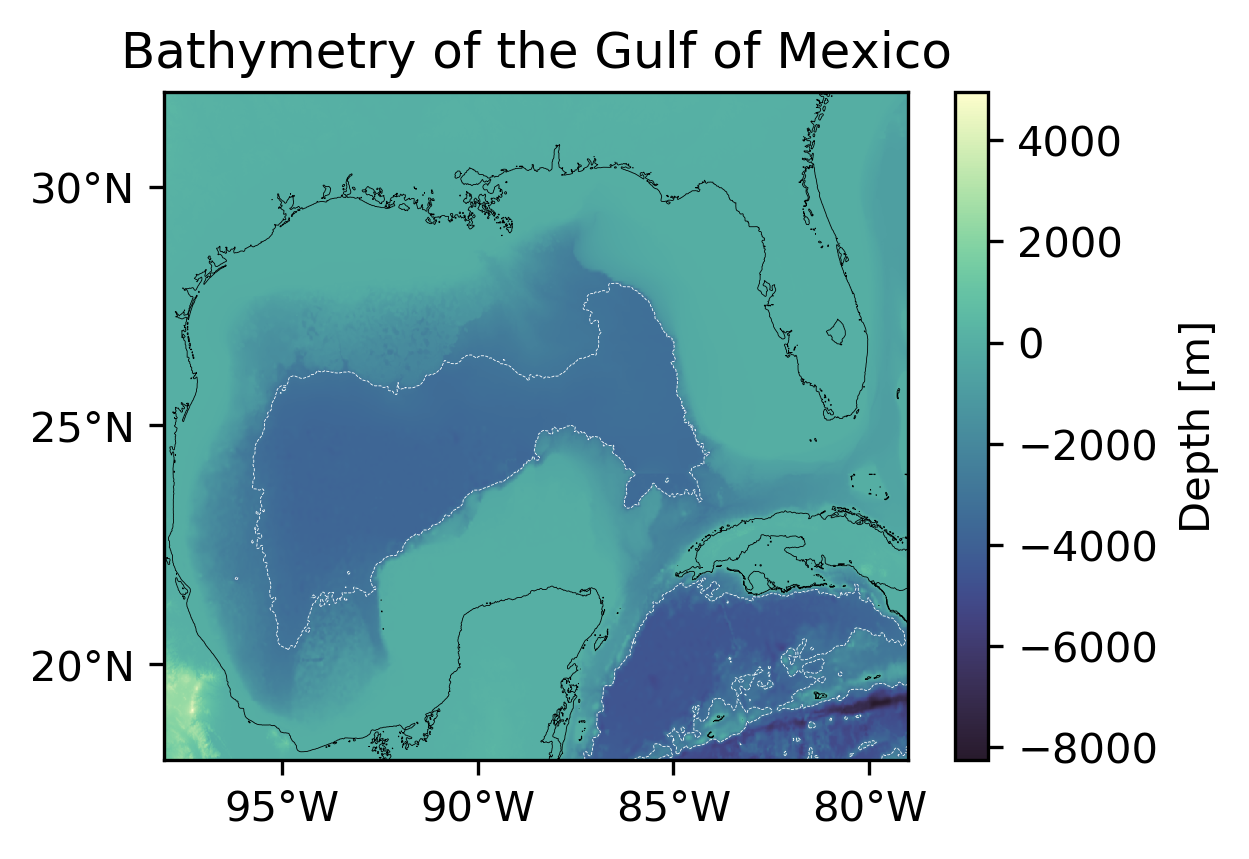

In [10]:
contour = False # plot using contour or pcolormesh

# GoM boundaries 
lon = [-98, -79]
lat = [18, 32]
elon, elat, ez = bathymetry_etopo(lon, lat) # define in the cell above

# figure parameters
ratio = (lat[1] - lat[0]) / (lon[1] - lon[0])
height = 4
width = height * ratio

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(height, width), dpi=300)

if contour:
    # filled contour of the depth of the GoM
    depth_c = ax.contourf(elon, elat, ez, np.arange(-7000, 100, 100), cmap=cmocean.cm.deep_r)

    # plot land in grey, thanks Milan for this trick
    eland = np.copy(ez)
    eland[eland > 0] = 30 # percent of black
    ax.contourf(elon, elat, eland, np.arange(0, 101, 1), cmap=cm.binary)
    
else:
    # pcolormesh: - values are at the center of the cell
    #             - supports NaN (transparent)
    depth_c = ax.pcolormesh(elon, elat, ez[:-1, :-1], cmap=cmocean.cm.deep_r)

# contour plot 3000m and coastlines
ax.contour(elon, elat, ez, [-3000], colors='white', linewidths=0.2)
ax.contour(elon, elat, ez, [0], colors='black', linewidths=0.2)

ax.set_title('Bathymetry of the Gulf of Mexico')
format_axis(ax, 5, 5) # axis cleanup using function define 2 cells above
cb = plt.colorbar(depth_c)
cb.set_label('Depth [m]', size=10, labelpad=5)

# 2. Subplots

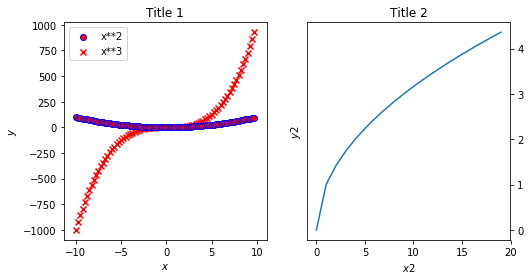

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# plot on the first axis
x = np.arange(-10,10,0.25)
lx3 = ax1.scatter(x, x**3, marker='x', c='r', edgecolor='black')
lx2 = ax1.scatter(x, x**2, marker='o', c='r', edgecolor='blue')

# by default the legend elements are added in order
# ax.legend(['x^2', 'x^3'], loc='upper left') # this would be wrong

# use the handle to plot elements (lx3, lx2)
ax1.legend([lx2, lx3], ['x**2', 'x**3'], loc='upper left')

ax1.set_title('Title 1')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

# plot on the second axis
x = np.arange(0,20)
ax2.plot(x, np.sqrt(x))
ax2.set_title('Title 2')
ax2.set_xlabel('$x2$')
ax2.set_ylabel('$y2$')
ax2.yaxis.tick_right()

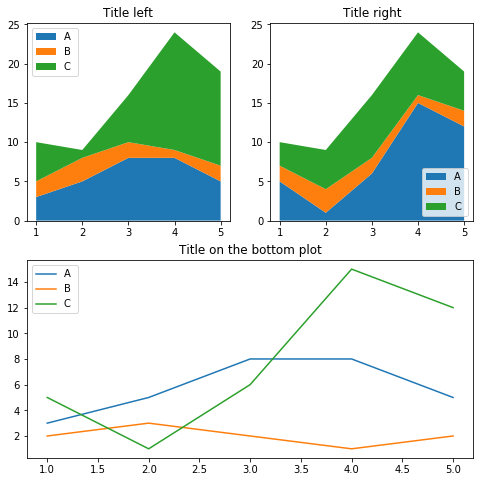

In [12]:
# data
x = [1, 2, 3, 4, 5]
y1 = np.random.randint(low=1, high=11, size=5)
y2 = np.random.randint(low=1, high=6, size=5)
y3 = np.random.randint(low=1, high=20, size=5)

labels = ["A ", "B", "C"]

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(2,2,1)
ax1.stackplot(x, y1, y2, y3, labels=labels)
ax1.set_title('Title left')
ax1.legend(loc='upper left')

# the data can be also join together with numpy
ax2 = fig.add_subplot(2,2,2)
ax2.stackplot(x, np.vstack([y3, y2, y1]), labels=labels) 
ax2.set_title('Title right')
ax2.legend(loc='lower right')

# bottom plot takes all width
ax3 = fig.add_subplot(2,1,2)
ax3.plot(x, y1, x, y2, x, y3)
ax3.set_title('Title on the bottom plot')
ax3.legend(labels)

# Importances of colormap


## cmocean
https://matplotlib.org/cmocean/




In [13]:
# from https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
    return cmap.from_list(cmap.name + "_grayscale", colors, cmap.N)

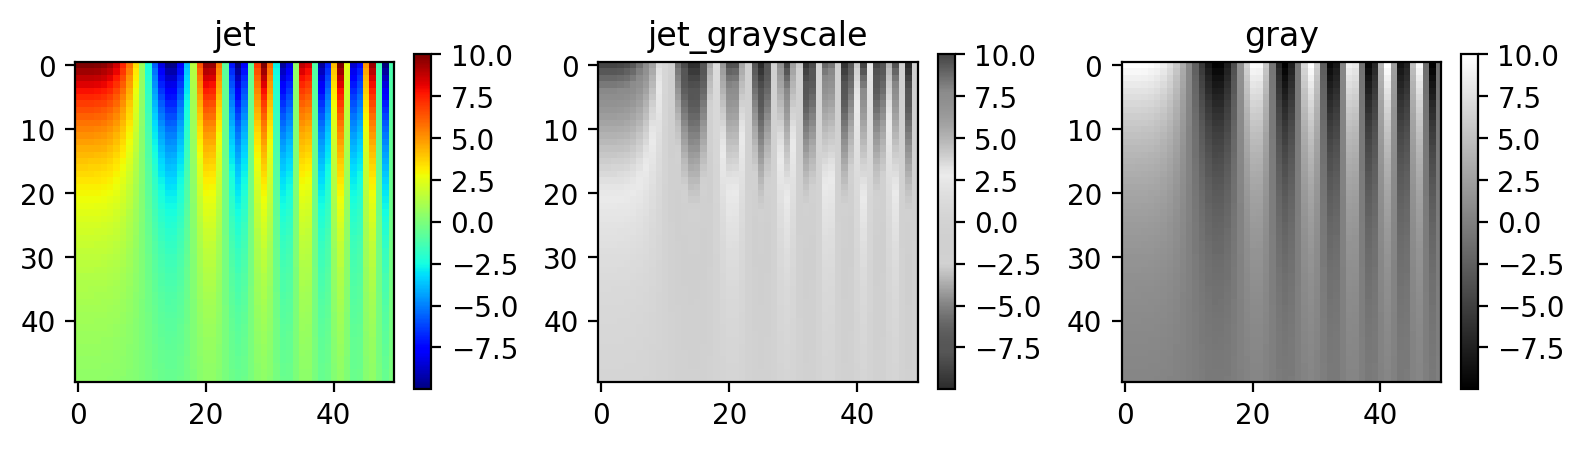

In [14]:
x = np.linspace(0, 6)
y = np.linspace(0, 3)[:, np.newaxis]
z = 10 * np.cos(x ** 2) * np.exp(-y)

cmaps = [plt.cm.jet, grayify_cmap('jet'), plt.cm.gray]
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200)
fig.subplots_adjust(wspace=0)

for cmap, ax in zip(cmaps, axes):
    im = ax.imshow(z, cmap=cmap)
    ax.set_title(cmap.name)
    fig.colorbar(im, ax=ax, shrink=0.62)
fig.tight_layout()

# Collections

https://github.com/tuxication/notebooks/blob/master/atlantic_storms.ipynb

# Mapping with Cartopy

## Trying the different projections

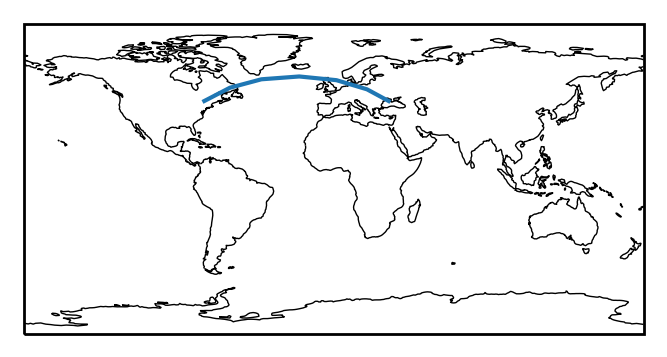

In [15]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidths=0.5)

x = np.array([-75, 32])
y = np.array([45, 45])
ax.plot(x,y,transform=ccrs.Geodetic())

# by default once you plot, the map will be zoom to the data
ax.set_global()

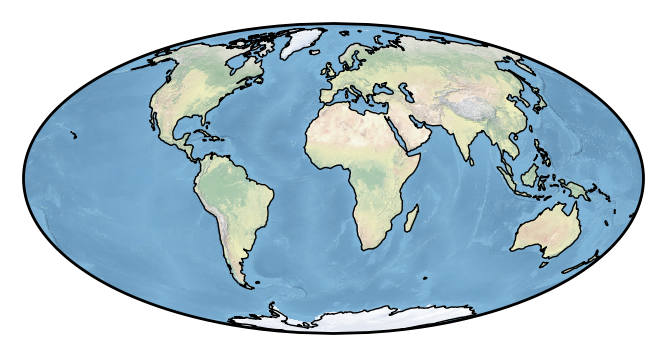

In [16]:
fig = plt.figure(figsize=(4, 4), dpi=200)
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.stock_img() # add an image on top of the current projections
ax.coastlines(linewidths=0.5)

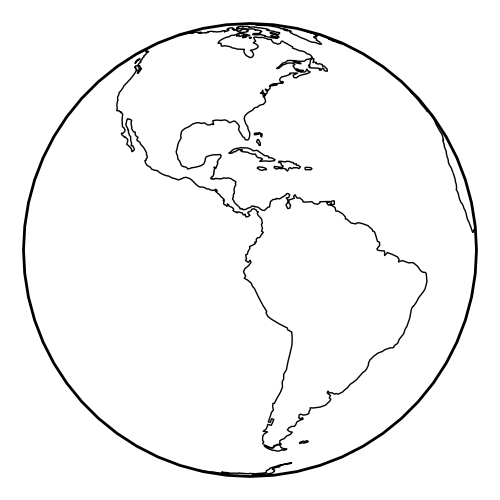

In [17]:
## Geostationary
fig = plt.figure(figsize=(3, 3), dpi=200)
ax = plt.axes(projection=ccrs.Geostationary(central_longitude = -80))
ax.coastlines(linewidths=0.5)

### NorthPolarStereo and SouthPolarStereo

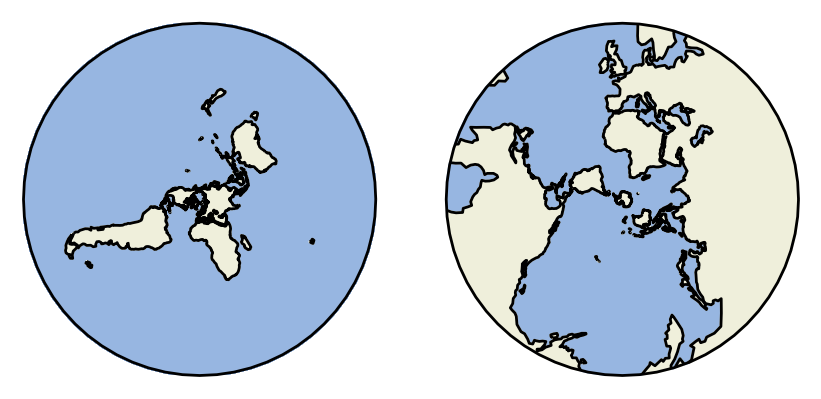

In [18]:
# from cartopy.feature we can add all kinds of map element
from cartopy.feature import OCEAN, LAND, COASTLINE

fig = plt.figure(figsize=(5, 4), dpi=200)

# looping two opposite projections
projections = [ccrs.NorthPolarStereo(), ccrs.SouthPolarStereo()]
for i, proj in enumerate(projections):
    ax = fig.add_subplot(1, 2, i+1, projection=proj)
    ax.add_feature(OCEAN)
    ax.add_feature(COASTLINE)
    ax.add_feature(LAND)

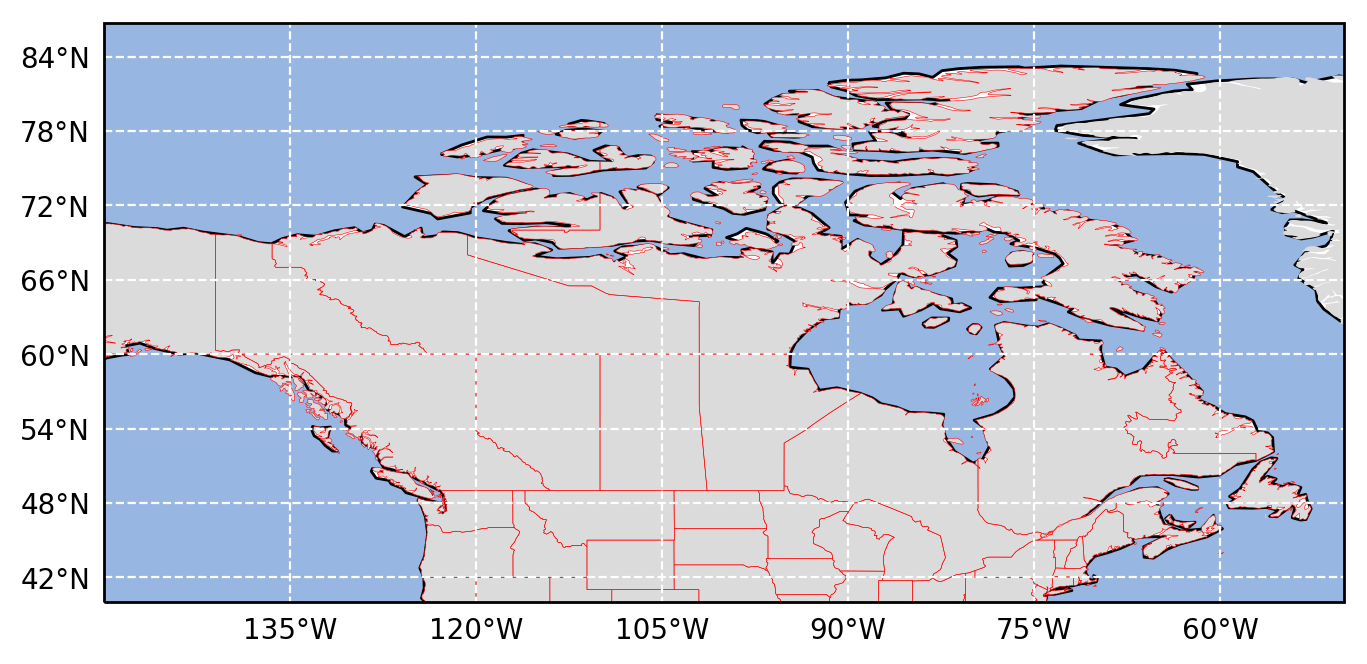

In [19]:
from cartopy.feature import NaturalEarthFeature, COLORS, OCEAN, LAND, COASTLINE
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# see features interface for more details about the parameters and different data available
# https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html

fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-150, -50, 40, 85])

# color land and ocean
ax.add_feature(OCEAN)
ax.add_feature(COASTLINE)
# ax.add_feature(LAND) like OCEAN and COASTLINES are shortcuts
land_50m = NaturalEarthFeature('physical', 'land', '50m', facecolor=COLORS['land_alt1'])
ax.add_feature(land_50m)

# add provinces again from NaturalEarthFeature
# this time it's in the 'cultural' category
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                         name='admin_1_states_provinces_shp')
ax.add_feature(states, edgecolor='red', linewidths=0.2)

# modify the labels
gl = ax.gridlines(draw_labels=True, linestyle='--', color='white')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

Text(0.5,1,'Who uses this projection ?')

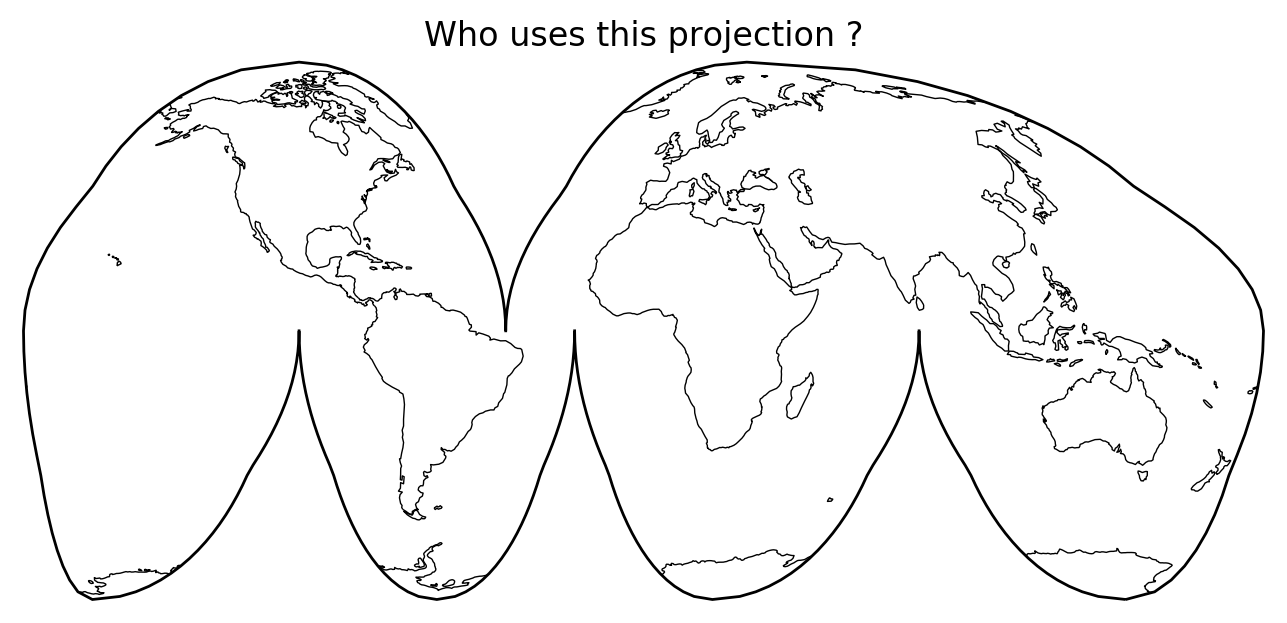

In [20]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.InterruptedGoodeHomolosine())
ax.coastlines(linewidths=0.5)
plt.title('Who uses this projection ?')

# Retriving data from THREED server - GOES 17

In [21]:
from datetime import datetime
from siphon.catalog import TDSCatalog # https://unidata.github.io/siphon/
import metpy
import xarray as xr

# get the latest SeaSurfaceTemperature from GOES 16
nowdate = datetime.utcnow()
catalog = TDSCatalog('http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/' 
                     + 'Products/SeaSurfaceTemperature/FullDisk/' + 
                     str(nowdate.year) + str("%02d"%nowdate.month) + str("%02d"%nowdate.day) + '/catalog.xml')

info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(catalog.base_tds_url,
           catalog.catalog_name,
           catalog.catalog_url,
           catalog.metadata)

print(info)


Catalog information
-------------------

Base THREDDS URL: https://thredds-jumbo.unidata.ucar.edu
Catalog name: No name found
Catalog URL: https://thredds-jumbo.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Products/SeaSurfaceTemperature/FullDisk/20181012/catalog.xml
Metadata: {'inherited': True, 'serviceName': 'GridServices', 'dataType': 'GRID', 'documentation': {'generic': ["NOAA's GOES-17 satellite has not been declared operational and its data are preliminary and undergoing testing. Users receiving these data through any dissemination means (including, but not limited to, PDA and GRB) assume all risk related to their use of GOES-17 data and NOAA disclaims any and all warranties, whether express or implied, including (without limitation) any implied warranties of merchantability or fitness for a particular purpose."]}}



In [22]:
# different services available
# not sure what this means ? I'm still learning!
for service in catalog.services:
    print(service.name)

latest
fullServices
GridServices


In [23]:
# we retrieved all the datasets of today
print('\n'.join(catalog.datasets.keys()))

OR_ABI-L2-SSTF-M3_G16_s20182842300379_e20182842356146_c20182850000217.nc
OR_ABI-L2-SSTF-M3_G16_s20182850000379_e20182850056146_c20182850100252.nc
OR_ABI-L2-SSTF-M3_G16_s20182850100379_e20182850156145_c20182850200158.nc
OR_ABI-L2-SSTF-M3_G16_s20182850200379_e20182850256146_c20182850300259.nc


In [24]:
# sort and get the latest (last) datasets
latest_dataset = sorted(catalog.datasets.keys())[-1]
dataset = catalog.datasets[latest_dataset]

# we now create an xarray from the data on the netCDF on the server
ds = dataset.remote_access(service='OPENDAP', use_xarray=True)

In [25]:
# parse the results to be able to plot it on any cartopy projections later
dqf = ds.metpy.parse_cf('DQF')  # [0,1,2,3] quality of values
sst = ds.metpy.parse_cf('SST')  # SST

In [26]:
# the data now have a projection associated with them
print(sst.metpy.cartopy_crs)

In [27]:
# keep sst where the data quality is good (no clouds!) and between realistic values
sst_corrected = sst.where(dqf == 0) # keep only values where quality is good
sst_corrected = sst_corrected.where(sst_corrected.variable > 273.15) # over 0°C
sst_corrected = sst_corrected.where(sst_corrected.variable < 318.15) # under 45°C
sst_corrected = sst_corrected - 273.15 # transform to Celsius

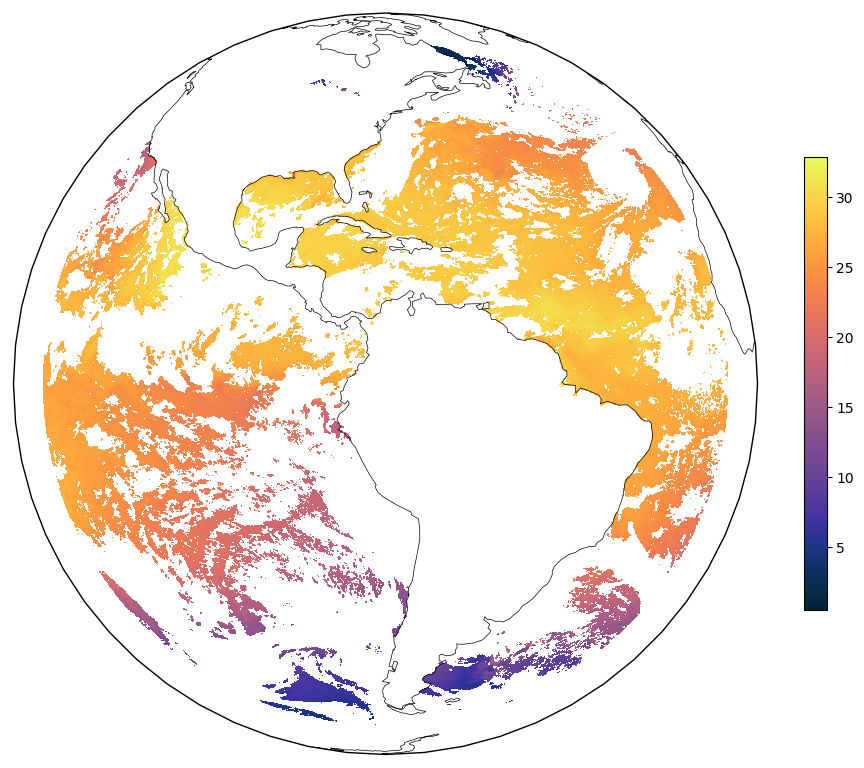

In [28]:
# this thing is surprisingly slow to plot
# I'm sorry from the bottom of my heart
fig = plt.figure(figsize=[12, 12], dpi=100)
ax = fig.add_subplot(1,1,1, projection=sst_corrected.metpy.cartopy_crs) # metpy projection from the data no need to transform because same projection !

im = ax.pcolormesh(sst_corrected['x'], sst_corrected['y'], sst_corrected, cmap=cmocean.cm.thermal, vmin=sst_corrected.min(), vmax=sst_corrected.max())
#im = ax.pcolormesh(sst['x'], sst['y'], sst, cmap=cmocean.cm.thermal, vmin=sst.min(), vmax=sst.max())

ax.coastlines(linewidths=0.5, zorder=2)

plt.colorbar(im, shrink=0.5)

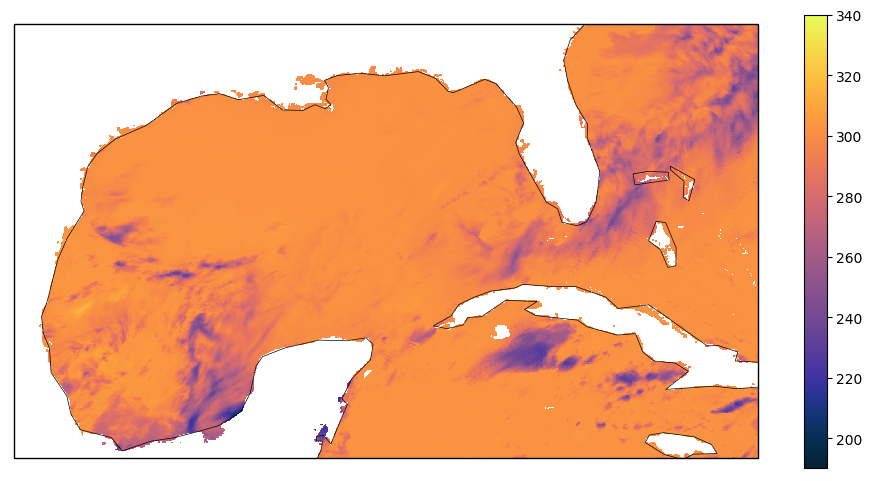

In [29]:
# zoom gulf of mexico
fig = plt.figure(figsize=[12, 12], dpi=100)

ax = fig.add_subplot(1,1,1, projection=sst.metpy.cartopy_crs) # metpy projection from the data
ax.set_extent([-98,-75, 18, 32])

im = ax.pcolormesh(sst['x'], sst['y'], sst, cmap=cmocean.cm.thermal, vmin=sst.min(), vmax=sst.max())

ax.coastlines(linewidths=0.5, zorder=2)

plt.colorbar(im, shrink=0.5)

# Retrieve GFS Forecast

In [30]:
from datetime import datetime
from siphon.catalog import TDSCatalog # https://unidata.github.io/siphon/
import metpy
import xarray as xr

# get the latest GFS forecast
nowdate = datetime(2018,10,11) # datetime.utcnow()
time = '0000'
catalog = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_' +
                     str(nowdate.year) + str("%02d"%nowdate.month) + str("%02d"%nowdate.day) + '_' + time+ '.grib2/catalog.html')


info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(catalog.base_tds_url,
           catalog.catalog_name,
           catalog.catalog_url,
           catalog.metadata)

print(info)


Catalog information
-------------------

Base THREDDS URL: http://thredds.ucar.edu
Catalog name: GFS_Global_0p25deg_20181011_0000.grib2
Catalog URL: http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20181011_0000.grib2/catalog.xml
Metadata: {'inherited': True, 'serviceName': 'fullServices', 'authority': ['edu.ucar.unidata'], 'dataType': 'GRID', 'dataFormat': 'GRIB-2', 'documentation': {'summary': ['Forecasts grids starting from the 0 hour forecast every 3 hours out to 10 days, then 12 hour forecasts for days 10-16.', 'NCEP GFS Model : AWIPS 230 (G) Grid. Global Lat/Lon grid. Model runs at 0, 6, 12, and 18Z. Horizontal= 721 by 14400 points, resolution 0.25 degree, Lat/Lon projection. Vertical= 1000 to 100 hPa mandatory pressure levels (26 levels); surface, height above ground, pressure layers.', 'NCEP Global Forecast System Model, previously called AVN/MRF (Medium Range Forecast)'], 'xlink': [{'title': 'COMET MetEd (Meteorology Education and Traini

/Users/phil/miniconda3/lib/python3.6/site-packages/siphon/catalog.py:268: UserWarning: URL http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20181011_0000.grib2/catalog.html returned HTML. Changing to: http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_20181011_0000.grib2/catalog.xml
  new_url))


In [31]:
# transform the forecast into xarray
dataset = catalog.datasets[0]
ds = dataset.remote_access(service='OPENDAP', use_xarray=True)

In [32]:
# look at the content of the datasets
ds

<xarray.Dataset>
Dimensions:                                                                     (altitude_above_msl: 3, depth_below_surface_layer: 4, depth_below_surface_layer_bounds_1: 2, height_above_ground: 1, height_above_ground1: 2, height_above_ground2: 1, height_above_ground3: 3, height_above_ground4: 3, height_above_ground_layer: 1, height_above_ground_layer1: 1, height_above_ground_layer1_bounds_1: 2, height_above_ground_layer_bounds_1: 2, isobaric: 31, isobaric1: 19, isobaric2: 1, isobaric3: 21, isobaric4: 26, isobaric5: 17, lat: 721, lon: 1440, potential_vorticity_surface: 2, pressure_difference_layer: 1, pressure_difference_layer1: 1, pressure_difference_layer1_bounds_1: 2, pressure_difference_layer2: 2, pressure_difference_layer2_bounds_1: 2, pressure_difference_layer_bounds_1: 2, sigma: 1, sigma_layer: 4, sigma_layer_bounds_1: 2, time: 62, time1: 69, time10: 69, time100: 78, time101: 65, time102: 64, time11: 66, time11_bounds_1: 2, time12: 63, time13: 69, time14: 62, tim

In [33]:
# now it's only a matter of finding what variable we watn to plot... for example let's try
# 'Temperature_surface'

# this could also retrieve the variable
#sst = ds['Temperature_surface'] 
 
# but this also prepare it to plot with cartopy! <3
sst = ds.metpy.parse_cf('Temperature_surface')  
print(sst.metpy.cartopy_crs) # gives us the coordinates of the data automatically

In [34]:
# 93 timesteps in the forecast (global grid is 721x1440)
# there is different 'time' variable associated with each of the variable...
sst

<xarray.DataArray 'Temperature_surface' (time35: 66, lat: 721, lon: 1440)>
[68523840 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0 88.75 88.5 88.25 88.0 ...
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 ...
    reftime  datetime64[ns] ...
  * time35   (time35) datetime64[ns] 2018-10-11 2018-10-11T03:00:00 ...
    crs      object Projection: latitude_longitude
Attributes:
    long_name:                      Temperature @ Ground or water surface
    units:                          K
    abbreviation:                   TMP
    Grib_Variable_Id:               VAR_0-0-0_L1
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

In [35]:
sst.shape

(66, 721, 1440)

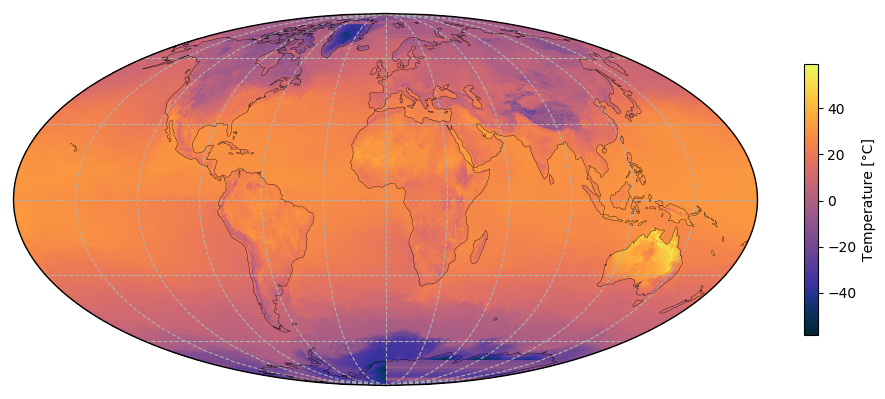

In [36]:
# let's plot a global map for the first time 2018-10-11T00:00:00.000000000
# When you plot the data: at this point it will download it from the server
timestep = 0
sst_plot = sst[timestep] - 273.15 # °K to °C

fig = plt.figure(figsize=[12, 12], dpi=100)
ax = fig.add_subplot(1,1,1, projection=ccrs.Mollweide()) # nice global projection
ax.set_global()


# the data are on a regular 2d grid so we have to use the transform keyword to use a projection different then PlateCarre()
im = ax.pcolormesh(sst['lon'], sst['lat'], sst_plot, cmap=cmocean.cm.thermal, transform=sst.metpy.cartopy_crs)
ax.coastlines(linewidths=0.25, zorder=2)

ax.gridlines(xlocs=np.arange(-180,210,30), ylocs=np.arange(-90,120,30),linestyle='--')
cb = plt.colorbar(im, shrink=0.3)
cb.set_label('Temperature [°C]')